# FNC Model aplicado ao Lançamento de Projétil

Esse notebook contém o modelo de rede neural FNC (Fully Convolutional Network) aplicado ao lançamento de um projétil
## Overview

Considere que o vetor posição é de tal forma que
$$
    \vec{r}(t) = (r_{x}(t), r_{y}(t))
$$

Onde a velocidade é dada por:

$$
    \vec{v}(t) = \left(\dfrac{dr_{x}}{dt}, \dfrac{dr_{y}}{dt}\right)
$$

A equação diferencial que governa o problema, é dada por:
$$
-\mu \left|\dfrac{d\vec{r}}{dt}\right|\dfrac{d\vec{r}}{dt} -\vec{g} - \dfrac{d^{2}\vec{r}}{dt^{2}} = 0
$$

Onde $\mu$ é um coeficiente de arraste normalizado pela massa.

# Import modules

In [12]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import matplotlib.pyplot as plt

# Define util functions

In [13]:
def saveGif(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def plotResult(x, y, x_data, y_data, labelY, labelY_data, title, fileName, yLimInf = -1, yLimSup = 1):
    plt.style.use('default')
    fig1 = plt.figure(figsize=(8,6))
    axes = fig1.add_axes([0.1,0.1,0.8,0.8])

    axes.plot(x, y, label=labelY)

    if(len(x_data) & len(y_data)):
        axes.scatter(x_data, y_data, color="tab:orange", label=labelY_data)
    
    axes.set_xlabel('x coordinate')
    axes.set_ylabel('y coordinate')

    axes.set_title(title)
    # plt.ylim([yLimInf, yLimSup])
    plt.legend()
    plt.grid(linestyle='-', linewidth=0.5)
    plt.savefig(fileName, dpi=400)


def plotPrettyResult(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Physical training data')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    # plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,1.0,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

# Define Runge-Kutta methods

In [14]:
def f(t, v, g, m, k):
    kmv = np.linalg.norm(v)*(k/m)
    return (g - kmv*v)

def RK4(tn, rn, vn, h, g, m, k):

    k1v = f(tn, vn, g, m, k)
    k2v = f(tn + h/2, vn + k1v*h/2, g, m, k)
    k3v = f(tn + h/2, vn + k2v*h/2, g, m, k)
    k4v = f(tn + h, vn + k3v*h, g, m, k)
    vn1 = vn + (k1v + 2*k2v + 2*k3v + k4v)*(h/6)

    k1r = vn
    k2r = vn + k1v*h/2
    k3r = vn + k2v*h/2
    k4r = vn + k3v*h
    rn1 = rn + (k1r + 2*k2r + 2*k3r + k4r)*(h/6)
    # xn1 = xn + vn*h + (k1v+k2v+k3v)*h**2/6

    return vn1, rn1

In [15]:
theta = np.radians(30)
v0 = np.array([8*np.cos(theta), 8*np.sin(theta)])
r0 = np.array([0, 0])
t0 = 0
r = []
v = [] 
t = []
r.append(r0)
v.append(v0)
t.append(t0)

m = 1
k = 0.001
g = np.array([0, -9.81])
h = 0.001

tn = t0
vn = v0
rn = r0
maxt = 1

while (tn < maxt):
   vn, rn = RK4(tn, rn, vn, h, g, m, k)
   tn = tn + h
   t.append(tn)
   r.append(rn)
   v.append(vn)

In [16]:
def parametricCoordinates(r):

    x = []
    y = []

    for position in r:
        x.append(position[0])
        y.append(position[1])

    return x, y

## Plot solutions

[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.010000000000000002, 0.011000000000000003, 0.012000000000000004, 0.013000000000000005, 0.014000000000000005, 0.015000000000000006, 0.016000000000000007, 0.017000000000000008, 0.01800000000000001, 0.01900000000000001, 0.02000000000000001, 0.02100000000000001, 0.022000000000000013, 0.023000000000000013, 0.024000000000000014, 0.025000000000000015, 0.026000000000000016, 0.027000000000000017, 0.028000000000000018, 0.02900000000000002, 0.03000000000000002, 0.03100000000000002, 0.03200000000000002, 0.03300000000000002, 0.03400000000000002, 0.035000000000000024, 0.036000000000000025, 0.037000000000000026, 0.03800000000000003, 0.03900000000000003, 0.04000000000000003, 0.04100000000000003, 0.04200000000000003, 0.04300000000000003, 0.04400000000000003, 0.04500000000000003, 0.046000000000000034, 0.047000000000000035, 0.048000000000000036, 0.04900000000000004, 0.05000000000000004, 0.05100000000000004, 0.0520000000000

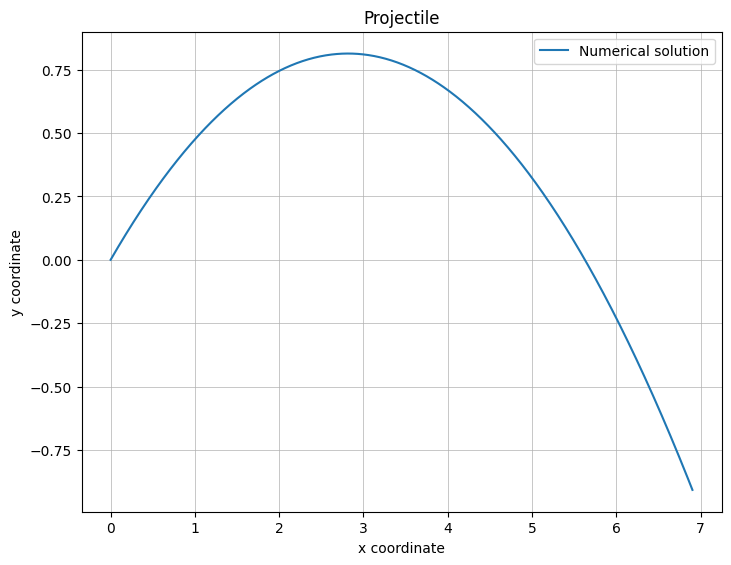

In [17]:
x, y = parametricCoordinates(r)

print(t)
plotResult(x, y, [], [], 'Numerical solution', 'Training data', 'Projectile', 'plots/projectile1.png')

# Define FNC

In [28]:
'''
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        self.fch = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
            ) for _ in range(N_LAYERS-1)]
        )
        self.fce_x = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.fce_y = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x, y):
        # Combine x and y inputs
        #xy = torch.cat((x.unsqueeze(1), y.unsqueeze(1)), dim=1)
        
        x = self.fcs(x)
        x = self.fch(x)
        # Output for position in x
        x_out = self.fce_x(x)
        
        y = self.fcs(y)
        y = self.fch(y)
        # Output for position in y
        y_out = self.fce_y(y)
        
        return x_out, y_out
'''

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        self.fch = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
            ) for _ in range(N_LAYERS-1)]
        )
        self.fce_x = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        # Combine x and y inputs
        #xy = torch.cat((x.unsqueeze(1), y.unsqueeze(1)), dim=1)
        
        x = self.fcs(x)
        x = self.fch(x)
        # Output for position in x
        x_out = self.fce_x(x)
        
        return x_out

### Generating data for training

In [19]:
x_data = x[0:400:40]
y_data = y[0:400:40]
t_data = t[0:400:40]

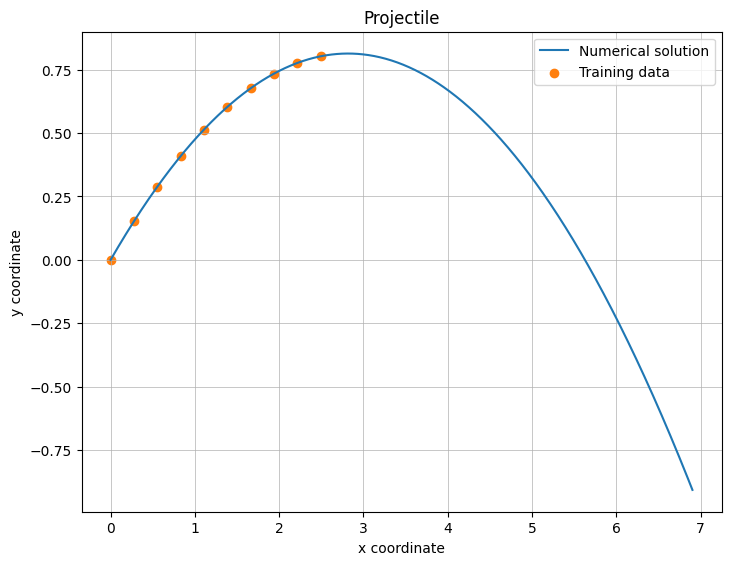

In [20]:
plotResult(x, y, x_data, y_data, 'Numerical solution', 'Training data', 'Projectile', 'plots/projectileTraining1.png')

### Using PINN

In [29]:
num_epochs = 1000

x_train_tensor = torch.tensor(x_data, dtype=torch.float32).unsqueeze(dim=1)
y_train_tensor = torch.tensor(y_data, dtype=torch.float32).unsqueeze(dim=1)

x_train_tensor.shape

x_train_tensor.requires_grad = True
y_train_tensor.requires_grad = True

In [37]:
model = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=2)

#yhp = model(x_physics)
#dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
#dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2

def loss_function(outputs, inputs, t):
    x, y = inputs
    x_pred, y_pred = outputs

    # Equação física do lançamento de projétil
    mu = 0.5  # constante qualquer
    g = torch.tensor([0, 9.8], dtype=torch.float32).unsqueeze(dim=1) # vetor gravidade

    dx = torch.autograd.grad(x_pred, x, torch.ones_like(x_pred), create_graph=True)# computes dx
    #dx2 = torch.autograd.grad(dx, x, torch.ones_like(dx), create_graph=True)# computes dx2
    dy = torch.autograd.grad(y_pred, y, torch.ones_like(y_pred), create_graph=True)# computes dx
    #dy2 = torch.autograd.grad(dy, y, torch.ones_like(dy), create_graph=True)# computes dx

    acceleration_x = -mu * dx*dx - g
    acceleration_y = -mu * dy*dy - g

    acceleration = acceleration_x, acceleration_y
    #acceleration = -mu * torch.norm(gradient(torch.cat((x_pred, y_pred), dim=1), torch.cat((x, y), dim=1))) * gradient(torch.cat((x_pred, y_pred), dim=1), torch.cat((x, y), dim=1)) - g

    loss = torch.mean(acceleration ** 2)

    return loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#inputs = torch.tensor([x_data, y_data]).t()

#print(inputs)
# Loop de treinamento
for epoch in range(num_epochs):
    # Forward pass
    output_x = model(x_train_tensor)
    output_y = model(y_train_tensor)

    outputs = output_x, output_y
    # Calcular a perda
    loss = loss_function(outputs, (x_train_tensor, y_train_tensor), t)
    
    # Backward pass e otimização
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Imprimir as métricas de treinamento, como loss, acurácia, etc.
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

TypeError: can't multiply sequence by non-int of type 'float'

In [24]:
# Definir a sua classe FCN aqui (com as modificações que já fizemos)


# Função para calcular a derivada parcial
def gradient(outputs, inputs):
    gradients = torch.autograd.grad(outputs, inputs, torch.ones_like(outputs), create_graph=True, allow_unused=True)
    return gradients[0]

# Função de perda que incorpora a equação física
def loss_function(outputs, inputs, t):
    x, y = inputs
    x_pred, y_pred = outputs

    print('x', x)
    print('y', y)
    print('x_pred', x_pred)
    print('y_pred', y_pred)
    print('x.shape', x.shape)
    print('y.shape', y.shape)
    print('x_pred.shape', x_pred.shape)
    print('y_pred.shape', y_pred.shape)

    # Equação física do lançamento de projétil
    mu = 0.5  # constante qualquer
    g = torch.tensor([0, 9.8])  # vetor gravidade
    acceleration = -mu * torch.norm(gradient(torch.cat((x_pred, y_pred), dim=1), torch.cat((x, y), dim=1))) * gradient(torch.cat((x_pred, y_pred), dim=1), torch.cat((x, y), dim=1)) - g

    loss = torch.mean(acceleration ** 2)

    return loss

# Configurações dos dados de treinamento
# ...

# Configurações da rede neural (número de hidden units, número de layers, etc.)
# ...

# Instanciar a rede neural
model = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=2)

# Configuração do otimizador Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#inputs = torch.tensor([x_data, y_data]).t()

#print(inputs)
# Loop de treinamento
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x = x_train_tensor, y = y_train_tensor)
    
    # Calcular a perda
    loss = loss_function(outputs, (x_train_tensor, y_train_tensor), t)
    
    # Backward pass e otimização
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Imprimir as métricas de treinamento, como loss, acurácia, etc.
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

x tensor([[0.0000],
        [0.2771],
        [0.5541],
        [0.8310],
        [1.1078],
        [1.3846],
        [1.6612],
        [1.9378],
        [2.2143],
        [2.4908]], requires_grad=True)
y tensor([[0.0000],
        [0.1521],
        [0.2885],
        [0.4092],
        [0.5141],
        [0.6033],
        [0.6768],
        [0.7345],
        [0.7766],
        [0.8029]], requires_grad=True)
x_pred tensor([[-0.2270],
        [-0.2335],
        [-0.2404],
        [-0.2469],
        [-0.2523],
        [-0.2567],
        [-0.2601],
        [-0.2630],
        [-0.2657],
        [-0.2686]], grad_fn=<AddmmBackward0>)
y_pred tensor([[-0.1939],
        [-0.1982],
        [-0.2004],
        [-0.2007],
        [-0.1998],
        [-0.1981],
        [-0.1962],
        [-0.1943],
        [-0.1928],
        [-0.1918]], grad_fn=<AddmmBackward0>)
x.shape torch.Size([10, 1])
y.shape torch.Size([10, 1])
x_pred.shape torch.Size([10, 1])
y_pred.shape torch.Size([10, 1])


AttributeError: 'NoneType' object has no attribute 'layout'